# Auto Regression

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [136]:
data = pd.read_csv("AirPassengers.csv")
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [137]:
# Set a random seed for reproducibility
np.random.seed(0)
 
# Make sure your "Date" column is in datetime format
data['Month'] = pd.to_datetime(data['Month'])

In [138]:
 # Sorting the data by date (if not sorted)
data = data.sort_values(by='Month')

In [139]:
 # Resetting the index
data.set_index('Month', inplace=True)

 
data.dropna(inplace=True)

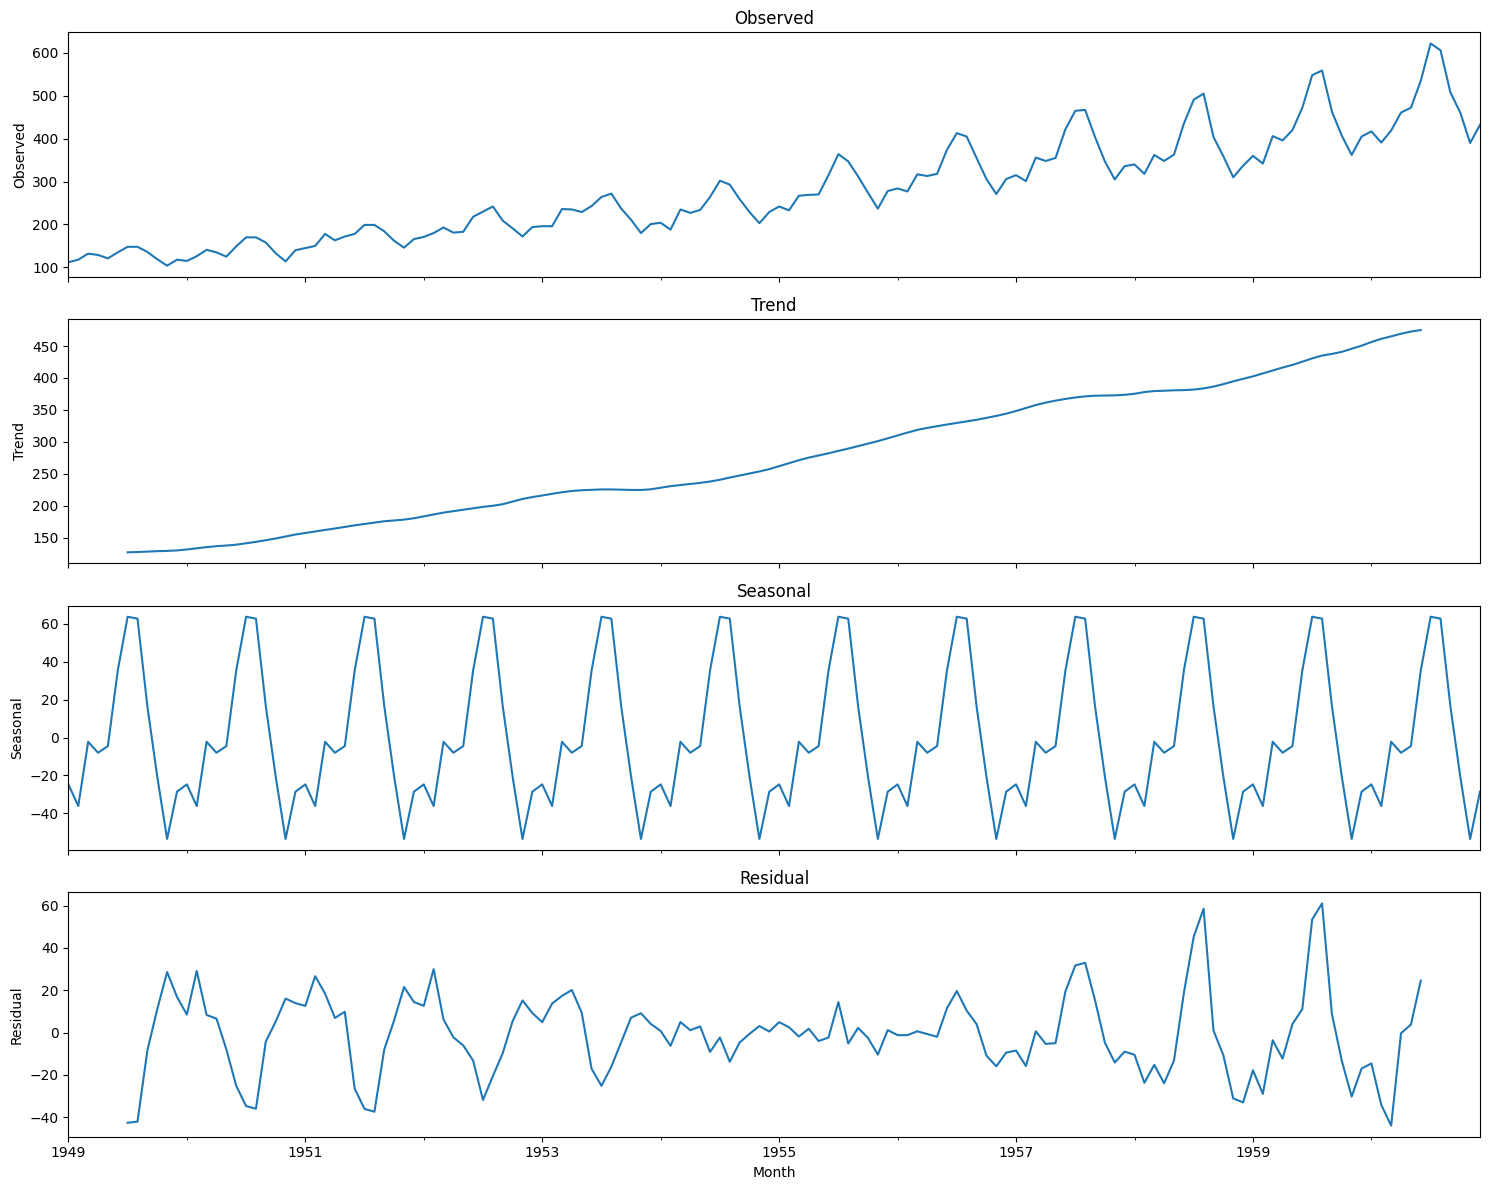

In [140]:
# Decompose the time series
result = seasonal_decompose(data['#Passengers'], model='additive') #period=12 by default
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, title='Trend')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, title='Residual')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Month')
plt.tight_layout()
plt.show()

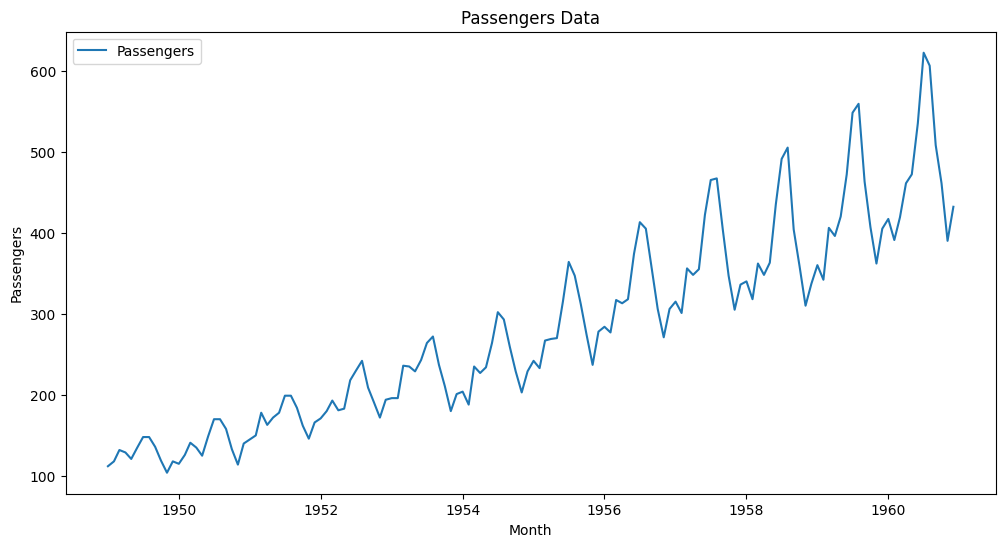

In [141]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot( data['#Passengers'], label='Passengers')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.title('Passengers Data')
plt.show()

In [142]:
# Adding lag features to the DataFrame
for i in range(1, 13): # Creating lag features up to 19 days
	data[f'Lag_{i}'] = data['#Passengers'].shift(i)

# Drop rows with NaN values resulting from creating lag features
data.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Define the input features (lag features) and target variable

y_train = train_data['#Passengers']

y_test = test_data['#Passengers']

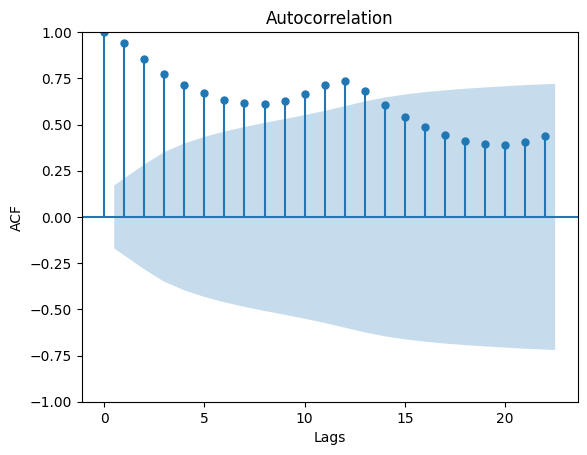

In [143]:
from statsmodels.graphics.tsaplots import plot_acf
series = data['#Passengers']
plot_acf(series)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

In [144]:
# Calculate and print the correlation between #Passengers and each lagged value
for i in range(1, 13):
    correlation = data['#Passengers'].corr(data[f'Lag_{i}'])
    print(f"AutoCorrelation between passengers and lag {i}: {correlation:.4f}")

AutoCorrelation between passengers and lag 1: 0.9543
AutoCorrelation between passengers and lag 2: 0.8822
AutoCorrelation between passengers and lag 3: 0.8187
AutoCorrelation between passengers and lag 4: 0.7768
AutoCorrelation between passengers and lag 5: 0.7659
AutoCorrelation between passengers and lag 6: 0.7657
AutoCorrelation between passengers and lag 7: 0.7689
AutoCorrelation between passengers and lag 8: 0.7798
AutoCorrelation between passengers and lag 9: 0.8198
AutoCorrelation between passengers and lag 10: 0.8789
AutoCorrelation between passengers and lag 11: 0.9489
AutoCorrelation between passengers and lag 12: 0.9905


In [145]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create and train the autoregressive model
lag_order = 12 # Adjust this based on the ACF plot
ar_model = AutoReg(y_train, lags=lag_order)
ar_results = ar_model.fit()

C:\Users\71524\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [146]:
# Make predictions on the test set
y_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
#print(y_pred)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 21.29
Root Mean Squared Error: 27.12


C:\Users\71524\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


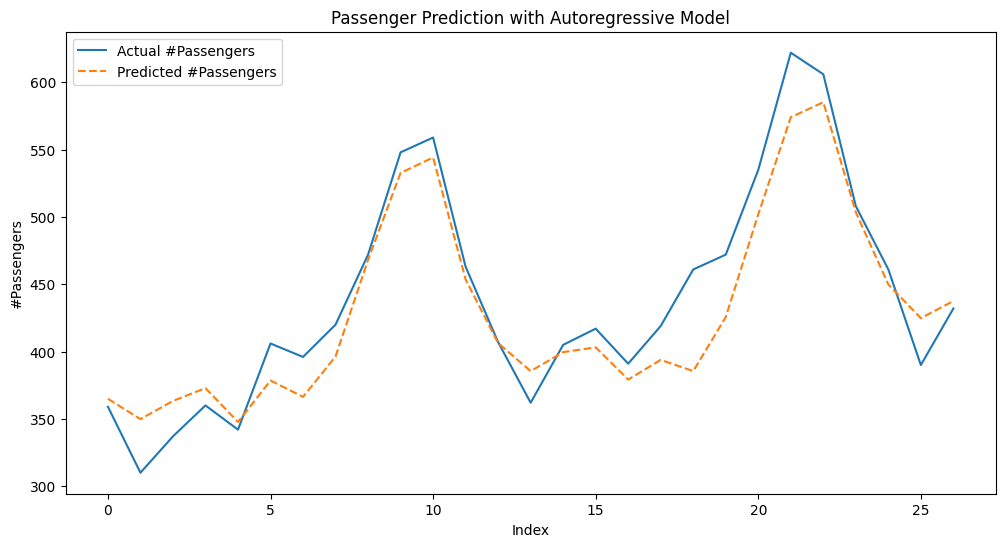

In [147]:
# Ensure the index for test_data is aligned correctly with y_pred
test_data.reset_index(drop=True, inplace=True)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual #Passengers')
plt.plot(test_data.index, y_pred, label='Predicted #Passengers', linestyle='--')
plt.xlabel('Index')
plt.ylabel('#Passengers')
plt.legend()
plt.title('Passenger Prediction with Autoregressive Model')
plt.show()

C:\Users\71524\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


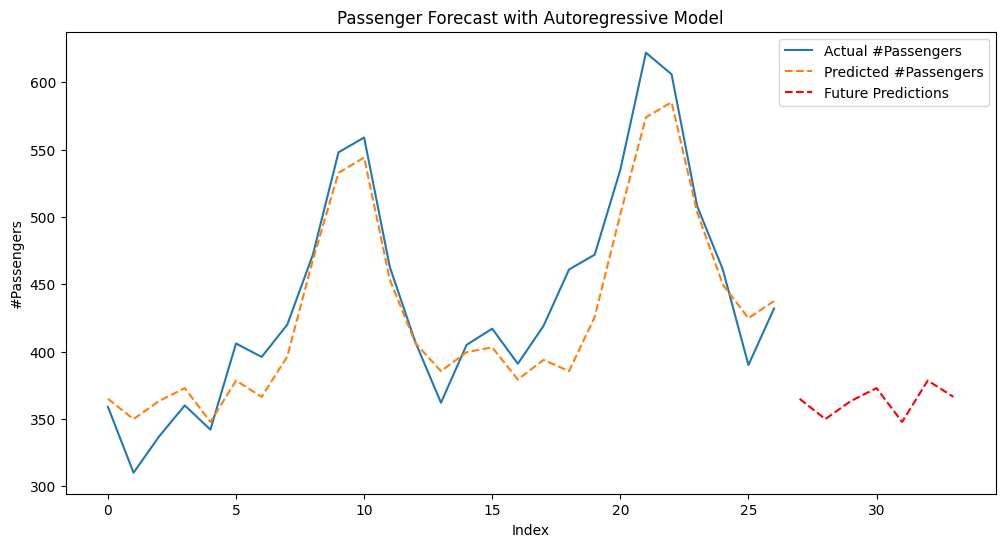

In [148]:
# Define the number of future time steps you want to predict
forecast_steps = 7

# Generate future indices
future_indices = range(len(y_test), len(y_test) + forecast_steps)

# Generate future predictions
future_predictions = ar_results.predict(start=len(train_data), end=len(train_data) + forecast_steps - 1, dynamic=False)

# Plot the actual data, existing predictions, and future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual #Passengers')
plt.plot(range(len(y_test)), y_pred, label='Predicted #Passengers', linestyle='--')
plt.plot(future_indices, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('#Passengers')
plt.legend()
plt.title('Passenger Forecast with Autoregressive Model')
plt.show()